In [1]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    return xx, yy


def plot_contours(Z, ax, clf, xx, yy, **params):
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)

    return out


def plot_graph(Z, xx, yy, ax, clf, X0, X1, y, title, mode='TRAIN'):
    plot_contours(Z, ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("Sepal length")
    ax.set_ylabel("Sepal width")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{title} {mode}")
    ax.set_title(f"{title} {mode}")


def evaluate_algorithm(metric_df, y_train_pred, y_train, y_test_pred, y_test, idx):
    metric_df.loc[idx, 'train_acc'] = accuracy_score(y_train_pred, y_train) * 100.
    metric_df.loc[idx, 'test_acc'] = accuracy_score(y_test_pred, y_test) * 100.

    for mode, y_pred, y in zip(['train', 'test'],
                               [y_train_pred, y_test_pred],
                               [y_train, y_test]):

        conf_matrix = confusion_matrix(y_pred, y)
        count_right = sum([conf_matrix[i, j]
                       for i in range(len(conf_matrix))
                       for j in range(len(conf_matrix[0]))
                       if i == j])
        count_false = sum(sum(conf_matrix)) - count_right
        metric_df.loc[idx, f'{mode}_count_right'] = count_right
        metric_df.loc[idx, f'{mode}_count_false'] = count_false

    return metric_df


def run_pipeline(X_train, X_test, y_train, y_test, metric_df):
    # Train/test split
    print(f"Train size = {len(X_train)} x {len(X_train[0])}")
    print(f"Test size = {len(X_test)} x {len(X_test[0])}")

    models = (
        svm.LinearSVC(C=1.),
        svm.SVC(kernel="linear", C=1.),
        svm.SVC(kernel="rbf", C=1.),
        svm.SVC(kernel="sigmoid", C=1.),
        svm.SVC(kernel="poly", C=1., degree=2),
        svm.SVC(kernel="poly", C=1., degree=3),
        svm.SVC(kernel="poly", C=1., degree=4),
        svm.SVC(kernel="poly", C=1., degree=5),
        svm.SVC(kernel="rbf", C=0.5),
        svm.SVC(kernel="rbf", C=5),
        svm.SVC(kernel="rbf", C=50),
        svm.NuSVC(kernel="rbf", nu=0.3),
        svm.NuSVC(kernel="rbf", nu=0.5),
        svm.NuSVC(kernel="rbf", nu=0.7),
    )

    models = (clf.fit(X_train, y_train) for clf in models)

    titles = (
        "LinearSVC (linear kernel)",
        "SVC linear kernel",
        "SVC RBF kernel",
        "SVC sigmoid kernel",
        "SVC polynomial (degree 2) kernel",
        "SVC polynomial (degree 3) kernel",
        "SVC polynomial (degree 4) kernel",
        "SVC polynomial (degree 5) kernel",
        "SVC RBF kernel (C=0.5)",
        "SVC RBF kernel (C=5)",
        "SVC RBF kernel (C=50)",
        "NuSVC RBF kernel (nu=0.3)",
        "NuSVC RBF kernel (nu=0.5)",
        "NuSVC RBF kernel (nu=0.7)"
    )

    fig, sub = plt.subplots(14, 2, figsize=(10,40))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0_train, X1_train = X_train[:, 0], X_train[:, 1]
    X0_test, X1_test = X_test[:, 0], X_test[:, 1]

    xx_train, yy_train = make_meshgrid(X0_train, X1_train)
    xx_test, yy_test = make_meshgrid(X0_test, X1_test)

    subplots_array = sub.flatten()

    for idx, (clf, title) in enumerate(zip(models, titles)):
        ax_train, ax_test = subplots_array[idx*2], subplots_array[idx*2 + 1]
        # train part
        Z_train = clf.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
        y_train_pred = clf.predict(X_train)
        plot_graph(Z_train, xx_train, yy_train, ax_train, clf, X0_train, X1_train, y_train, title, mode='TRAIN')
        # test part
        Z_test = clf.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
        y_test_pred = clf.predict(X_test)
        plot_graph(Z_test, xx_test, yy_test, ax_test, clf, X0_test, X1_test, y_test, title, mode='TEST')
        # evaluate
        metric_df = evaluate_algorithm(metric_df, y_train_pred, y_train, y_test_pred, y_test, idx)

    plt.show();

    change_type_list = ['train_count_right', 'train_count_false', 'test_count_right', 'test_count_false']
    metric_df[change_type_list] = metric_df[change_type_list].astype('int')

    return metric_df

In [3]:
params = (
    {
        'method': 'LinearSVC',
        'kernel': np.NaN,
        'C': 1.,
        'degree': np.NaN,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'linear',
        'C': 1.,
        'degree': np.NaN,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'rbf',
        'C': 1.,
        'degree': np.NaN,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'sigmoid',
        'C': 1.,
        'degree': np.NaN,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'poly',
        'C': 1.,
        'degree': 2,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'poly',
        'C': 1.,
        'degree': 3,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'poly',
        'C': 1.,
        'degree': 4,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'poly',
        'C': 1.,
        'degree': 5,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'rbf',
        'C': 0.5,
        'degree': np.NaN,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'rbf',
        'C': 5,
        'degree': np.NaN,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'SVC',
        'kernel': 'rbf',
        'C': 50,
        'degree': np.NaN,
        'nu': np.NaN,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'NuSVC',
        'kernel': 'rbf',
        'C': np.NaN,
        'degree': np.NaN,
        'nu': 0.3,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'NuSVC',
        'kernel': 'rbf',
        'C': np.NaN,
        'degree': np.NaN,
        'nu': 0.5,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    },
    {
        'method': 'NuSVC',
        'kernel': 'rbf',
        'C': np.NaN,
        'degree': np.NaN,
        'nu': 0.7,
        'train_acc': np.NaN,
        'test_acc': np.NaN,
    }
)
metric_df = pd.DataFrame(params)
metric_df

method   kernel     C  degree   nu  train_acc  test_acc
0   LinearSVC      NaN   1.0     NaN  NaN        NaN       NaN
1         SVC   linear   1.0     NaN  NaN        NaN       NaN
2         SVC      rbf   1.0     NaN  NaN        NaN       NaN
3         SVC  sigmoid   1.0     NaN  NaN        NaN       NaN
4         SVC     poly   1.0     2.0  NaN        NaN       NaN
5         SVC     poly   1.0     3.0  NaN        NaN       NaN
6         SVC     poly   1.0     4.0  NaN        NaN       NaN
7         SVC     poly   1.0     5.0  NaN        NaN       NaN
8         SVC      rbf   0.5     NaN  NaN        NaN       NaN
9         SVC      rbf   5.0     NaN  NaN        NaN       NaN
10        SVC      rbf  50.0     NaN  NaN        NaN       NaN
11      NuSVC      rbf   NaN     NaN  0.3        NaN       NaN
12      NuSVC      rbf   NaN     NaN  0.5        NaN       NaN
13      NuSVC      rbf   NaN     NaN  0.7        NaN       NaN

Train size = 105 x 2
Test size = 45 x 2


C:\ProgramData\Anaconda3\envs\ba-env\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


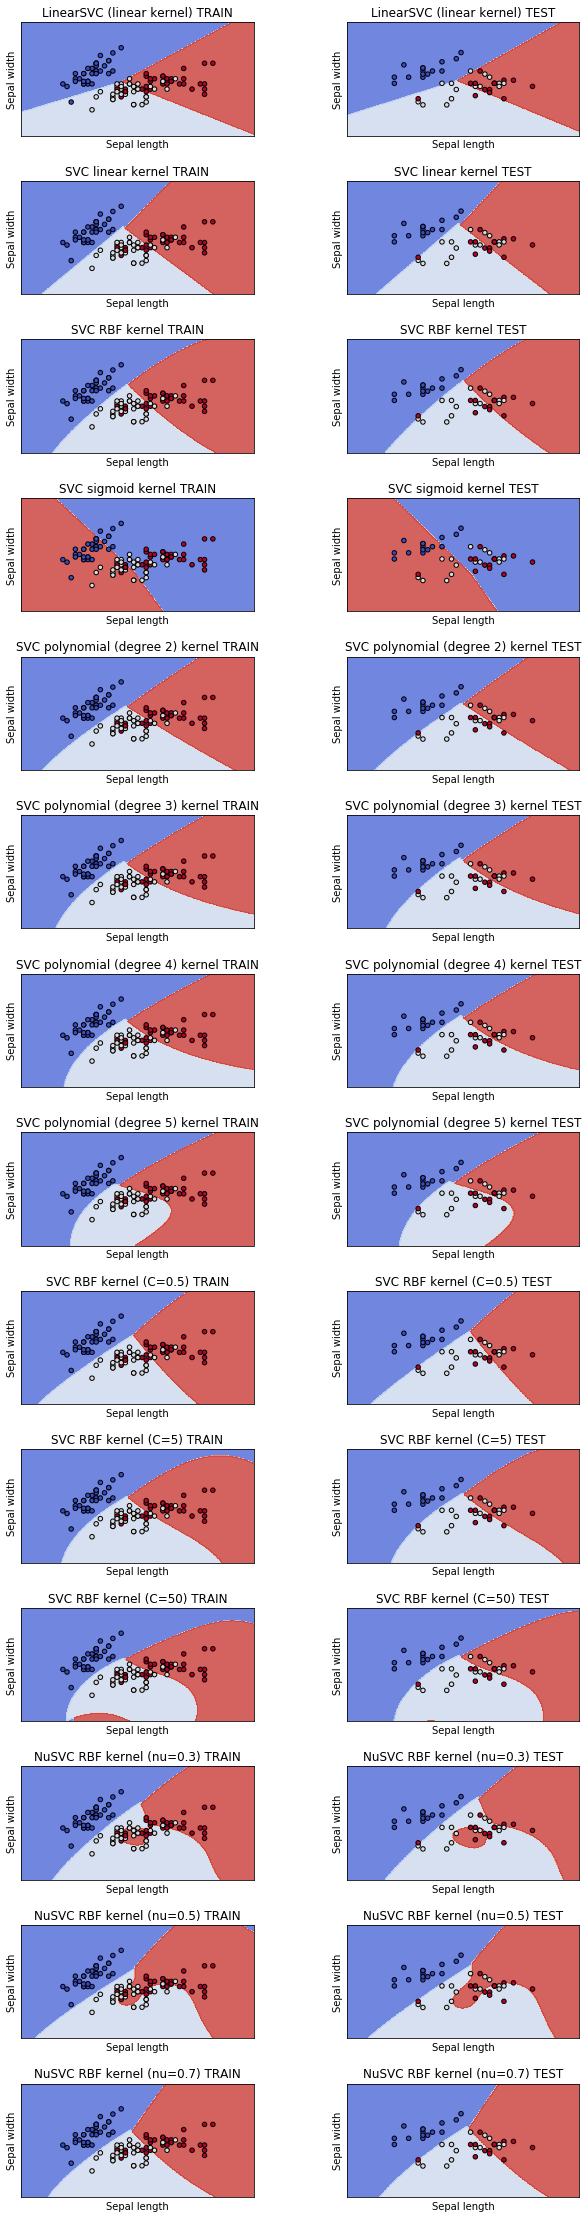

method   kernel     C  degree   nu  train_acc   test_acc  \
0   LinearSVC      NaN   1.0     NaN  NaN  81.904762  75.555556   
1         SVC   linear   1.0     NaN  NaN  81.904762  71.111111   
2         SVC      rbf   1.0     NaN  NaN  81.904762  73.333333   
3         SVC  sigmoid   1.0     NaN  NaN  12.380952   8.888889   
4         SVC     poly   1.0     2.0  NaN  81.904762  68.888889   
5         SVC     poly   1.0     3.0  NaN  83.809524  68.888889   
6         SVC     poly   1.0     4.0  NaN  83.809524  68.888889   
7         SVC     poly   1.0     5.0  NaN  83.809524  68.888889   
8         SVC      rbf   0.5     NaN  NaN  81.904762  73.333333   
9         SVC      rbf   5.0     NaN  NaN  81.904762  68.888889   
10        SVC      rbf  50.0     NaN  NaN  83.809524  68.888889   
11      NuSVC      rbf   NaN     NaN  0.3  74.285714  75.555556   
12      NuSVC      rbf   NaN     NaN  0.5  80.000000  73.333333   
13      NuSVC      rbf   NaN     NaN  0.7  81.904762  73.333333   

    train_count_right  train_count_false  test_count_right  test_count_false  
0                  86                 19                34                11  
1                  86                 19                32                13  
2                  86                 19                33                12  
3                  13                 92                 4                41  
4                  86                 19                31                14  
5                  88                 17                31                14  
6                  88                 17                31                14  
7                  88                 17                31                14  
8                  86                 19                33                12  
9                  86                 19                31                14  
10                 88                 17                31                14  
11                 78                 27                34                11  
12                 84                 21                33                12  
13                 86                 19                33                12

In [4]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
metric_df = run_pipeline(X_train, X_test, y_train, y_test, metric_df)
metric_df

In [5]:
metric_df.sort_values('test_acc', ascending=False)

method   kernel     C  degree   nu  train_acc   test_acc  \
0   LinearSVC      NaN   1.0     NaN  NaN  81.904762  75.555556   
11      NuSVC      rbf   NaN     NaN  0.3  74.285714  75.555556   
2         SVC      rbf   1.0     NaN  NaN  81.904762  73.333333   
8         SVC      rbf   0.5     NaN  NaN  81.904762  73.333333   
12      NuSVC      rbf   NaN     NaN  0.5  80.000000  73.333333   
13      NuSVC      rbf   NaN     NaN  0.7  81.904762  73.333333   
1         SVC   linear   1.0     NaN  NaN  81.904762  71.111111   
4         SVC     poly   1.0     2.0  NaN  81.904762  68.888889   
5         SVC     poly   1.0     3.0  NaN  83.809524  68.888889   
6         SVC     poly   1.0     4.0  NaN  83.809524  68.888889   
7         SVC     poly   1.0     5.0  NaN  83.809524  68.888889   
9         SVC      rbf   5.0     NaN  NaN  81.904762  68.888889   
10        SVC      rbf  50.0     NaN  NaN  83.809524  68.888889   
3         SVC  sigmoid   1.0     NaN  NaN  12.380952   8.888889   

    train_count_right  train_count_false  test_count_right  test_count_false  
0                  86                 19                34                11  
11                 78                 27                34                11  
2                  86                 19                33                12  
8                  86                 19                33                12  
12                 84                 21                33                12  
13                 86                 19                33                12  
1                  86                 19                32                13  
4                  86                 19                31                14  
5                  88                 17                31                14  
6                  88                 17                31                14  
7                  88                 17                31                14  
9                  86                 19                31                14  
10                 88                 17                31                14  
3                  13                 92                 4                41

Train size = 85 x 2
Test size = 45 x 2


C:\ProgramData\Anaconda3\envs\ba-env\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


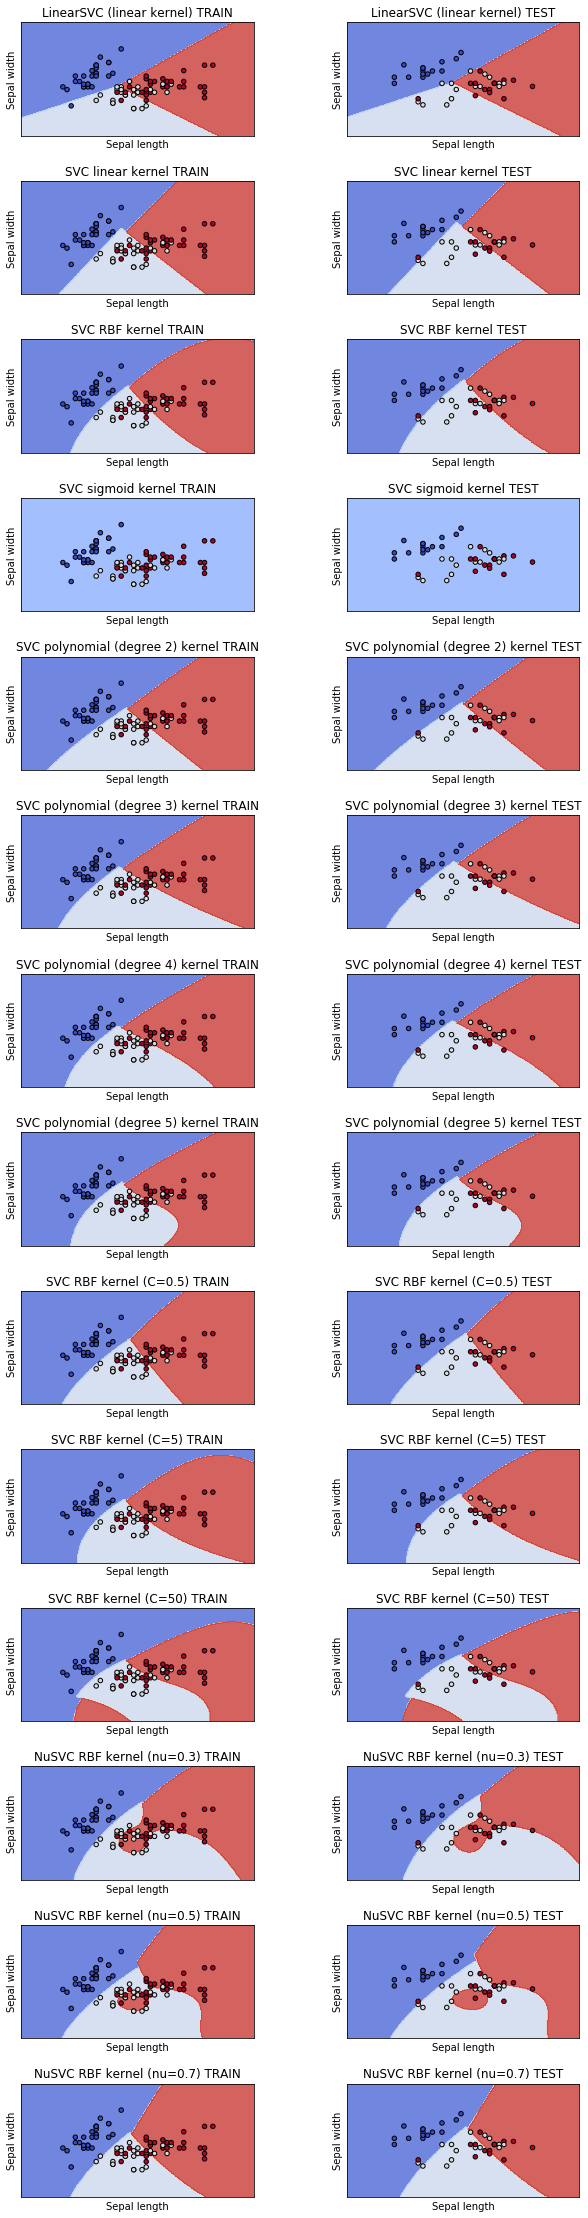

method   kernel     C  degree   nu  train_acc   test_acc  \
0   LinearSVC      NaN   1.0     NaN  NaN  80.000000  75.555556   
1         SVC   linear   1.0     NaN  NaN  81.176471  68.888889   
2         SVC      rbf   1.0     NaN  NaN  82.352941  73.333333   
3         SVC  sigmoid   1.0     NaN  NaN  35.294118  33.333333   
4         SVC     poly   1.0     2.0  NaN  83.529412  73.333333   
5         SVC     poly   1.0     3.0  NaN  82.352941  68.888889   
6         SVC     poly   1.0     4.0  NaN  81.176471  68.888889   
7         SVC     poly   1.0     5.0  NaN  81.176471  68.888889   
8         SVC      rbf   0.5     NaN  NaN  83.529412  75.555556   
9         SVC      rbf   5.0     NaN  NaN  83.529412  71.111111   
10        SVC      rbf  50.0     NaN  NaN  82.352941  68.888889   
11      NuSVC      rbf   NaN     NaN  0.3  78.823529  75.555556   
12      NuSVC      rbf   NaN     NaN  0.5  80.000000  68.888889   
13      NuSVC      rbf   NaN     NaN  0.7  80.000000  68.888889   

    train_count_right  train_count_false  test_count_right  test_count_false  
0                  68                 17                34                11  
1                  69                 16                31                14  
2                  70                 15                33                12  
3                  30                 55                15                30  
4                  71                 14                33                12  
5                  70                 15                31                14  
6                  69                 16                31                14  
7                  69                 16                31                14  
8                  71                 14                34                11  
9                  71                 14                32                13  
10                 70                 15                31                14  
11                 67                 18                34                11  
12                 68                 17                31                14  
13                 68                 17                31                14

In [6]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, y_train = X_train[:-20, :], y_train[:-20]
metric_df = run_pipeline(X_train, X_test, y_train, y_test, metric_df)
metric_df

In [7]:
metric_df.sort_values('test_acc', ascending=False)

method   kernel     C  degree   nu  train_acc   test_acc  \
0   LinearSVC      NaN   1.0     NaN  NaN  80.000000  75.555556   
8         SVC      rbf   0.5     NaN  NaN  83.529412  75.555556   
11      NuSVC      rbf   NaN     NaN  0.3  78.823529  75.555556   
2         SVC      rbf   1.0     NaN  NaN  82.352941  73.333333   
4         SVC     poly   1.0     2.0  NaN  83.529412  73.333333   
9         SVC      rbf   5.0     NaN  NaN  83.529412  71.111111   
1         SVC   linear   1.0     NaN  NaN  81.176471  68.888889   
5         SVC     poly   1.0     3.0  NaN  82.352941  68.888889   
6         SVC     poly   1.0     4.0  NaN  81.176471  68.888889   
7         SVC     poly   1.0     5.0  NaN  81.176471  68.888889   
10        SVC      rbf  50.0     NaN  NaN  82.352941  68.888889   
12      NuSVC      rbf   NaN     NaN  0.5  80.000000  68.888889   
13      NuSVC      rbf   NaN     NaN  0.7  80.000000  68.888889   
3         SVC  sigmoid   1.0     NaN  NaN  35.294118  33.333333   

    train_count_right  train_count_false  test_count_right  test_count_false  
0                  68                 17                34                11  
8                  71                 14                34                11  
11                 67                 18                34                11  
2                  70                 15                33                12  
4                  71                 14                33                12  
9                  71                 14                32                13  
1                  69                 16                31                14  
5                  70                 15                31                14  
6                  69                 16                31                14  
7                  69                 16                31                14  
10                 70                 15                31                14  
12                 68                 17                31                14  
13                 68                 17                31                14  
3                  30                 55                15                30

Train size = 65 x 2
Test size = 45 x 2


C:\ProgramData\Anaconda3\envs\ba-env\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


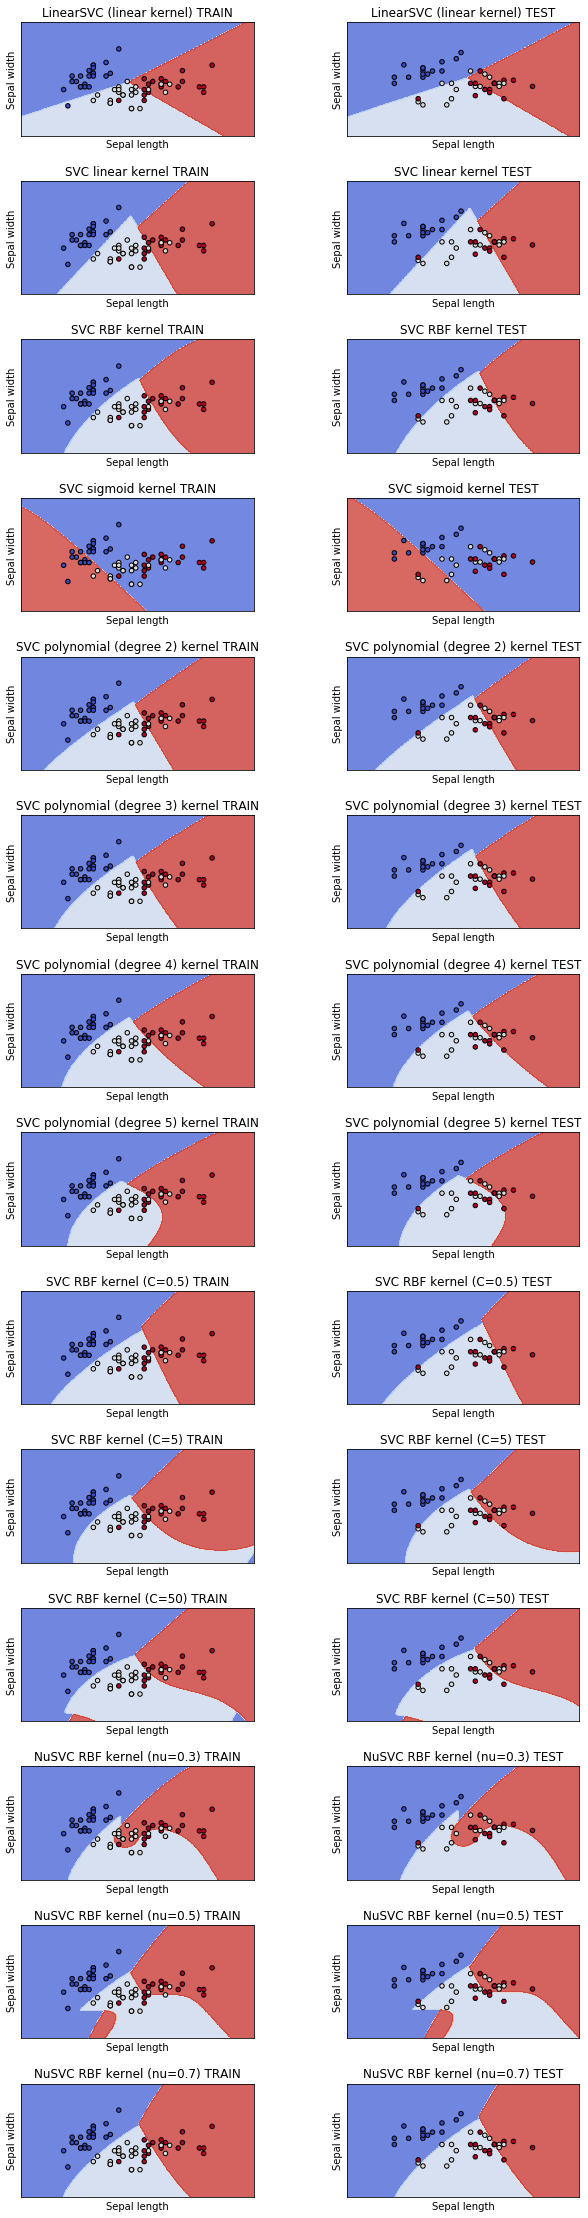

method   kernel     C  degree   nu  train_acc   test_acc  \
0   LinearSVC      NaN   1.0     NaN  NaN  83.076923  66.666667   
1         SVC   linear   1.0     NaN  NaN  84.615385  68.888889   
2         SVC      rbf   1.0     NaN  NaN  81.538462  73.333333   
3         SVC  sigmoid   1.0     NaN  NaN  24.615385  31.111111   
4         SVC     poly   1.0     2.0  NaN  84.615385  75.555556   
5         SVC     poly   1.0     3.0  NaN  83.076923  73.333333   
6         SVC     poly   1.0     4.0  NaN  84.615385  73.333333   
7         SVC     poly   1.0     5.0  NaN  84.615385  68.888889   
8         SVC      rbf   0.5     NaN  NaN  81.538462  66.666667   
9         SVC      rbf   5.0     NaN  NaN  83.076923  71.111111   
10        SVC      rbf  50.0     NaN  NaN  84.615385  71.111111   
11      NuSVC      rbf   NaN     NaN  0.3  70.769231  66.666667   
12      NuSVC      rbf   NaN     NaN  0.5  84.615385  71.111111   
13      NuSVC      rbf   NaN     NaN  0.7  81.538462  62.222222   

    train_count_right  train_count_false  test_count_right  test_count_false  
0                  54                 11                30                15  
1                  55                 10                31                14  
2                  53                 12                33                12  
3                  16                 49                14                31  
4                  55                 10                34                11  
5                  54                 11                33                12  
6                  55                 10                33                12  
7                  55                 10                31                14  
8                  53                 12                30                15  
9                  54                 11                32                13  
10                 55                 10                32                13  
11                 46                 19                30                15  
12                 55                 10                32                13  
13                 53                 12                28                17

In [8]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, y_train = X_train[:-40, :], y_train[:-40]
metric_df = run_pipeline(X_train, X_test, y_train, y_test, metric_df)
metric_df

In [9]:
metric_df.sort_values('test_acc', ascending=False)

method   kernel     C  degree   nu  train_acc   test_acc  \
4         SVC     poly   1.0     2.0  NaN  84.615385  75.555556   
2         SVC      rbf   1.0     NaN  NaN  81.538462  73.333333   
5         SVC     poly   1.0     3.0  NaN  83.076923  73.333333   
6         SVC     poly   1.0     4.0  NaN  84.615385  73.333333   
9         SVC      rbf   5.0     NaN  NaN  83.076923  71.111111   
10        SVC      rbf  50.0     NaN  NaN  84.615385  71.111111   
12      NuSVC      rbf   NaN     NaN  0.5  84.615385  71.111111   
1         SVC   linear   1.0     NaN  NaN  84.615385  68.888889   
7         SVC     poly   1.0     5.0  NaN  84.615385  68.888889   
0   LinearSVC      NaN   1.0     NaN  NaN  83.076923  66.666667   
8         SVC      rbf   0.5     NaN  NaN  81.538462  66.666667   
11      NuSVC      rbf   NaN     NaN  0.3  70.769231  66.666667   
13      NuSVC      rbf   NaN     NaN  0.7  81.538462  62.222222   
3         SVC  sigmoid   1.0     NaN  NaN  24.615385  31.111111   

    train_count_right  train_count_false  test_count_right  test_count_false  
4                  55                 10                34                11  
2                  53                 12                33                12  
5                  54                 11                33                12  
6                  55                 10                33                12  
9                  54                 11                32                13  
10                 55                 10                32                13  
12                 55                 10                32                13  
1                  55                 10                31                14  
7                  55                 10                31                14  
0                  54                 11                30                15  
8                  53                 12                30                15  
11                 46                 19                30                15  
13                 53                 12                28                17  
3                  16                 49                14                31

Train size = 45 x 2
Test size = 45 x 2


C:\ProgramData\Anaconda3\envs\ba-env\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


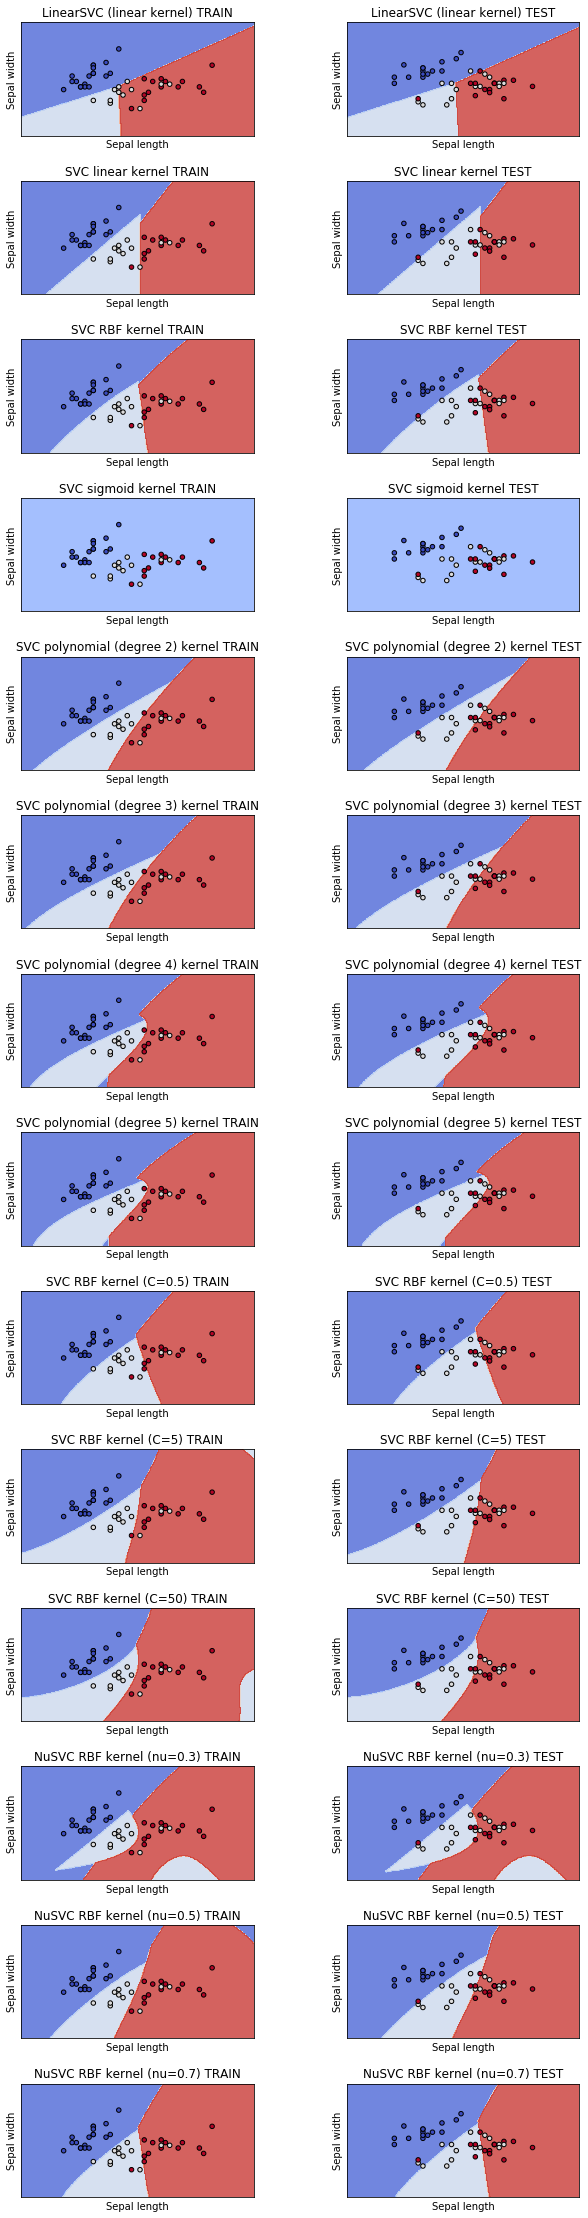

method   kernel     C  degree   nu  train_acc   test_acc  \
0   LinearSVC      NaN   1.0     NaN  NaN  82.222222  71.111111   
1         SVC   linear   1.0     NaN  NaN  93.333333  77.777778   
2         SVC      rbf   1.0     NaN  NaN  93.333333  80.000000   
3         SVC  sigmoid   1.0     NaN  NaN  42.222222  33.333333   
4         SVC     poly   1.0     2.0  NaN  91.111111  80.000000   
5         SVC     poly   1.0     3.0  NaN  91.111111  80.000000   
6         SVC     poly   1.0     4.0  NaN  91.111111  82.222222   
7         SVC     poly   1.0     5.0  NaN  91.111111  82.222222   
8         SVC      rbf   0.5     NaN  NaN  86.666667  73.333333   
9         SVC      rbf   5.0     NaN  NaN  91.111111  80.000000   
10        SVC      rbf  50.0     NaN  NaN  93.333333  80.000000   
11      NuSVC      rbf   NaN     NaN  0.3  93.333333  77.777778   
12      NuSVC      rbf   NaN     NaN  0.5  93.333333  77.777778   
13      NuSVC      rbf   NaN     NaN  0.7  91.111111  73.333333   

    train_count_right  train_count_false  test_count_right  test_count_false  
0                  37                  8                32                13  
1                  42                  3                35                10  
2                  42                  3                36                 9  
3                  19                 26                15                30  
4                  41                  4                36                 9  
5                  41                  4                36                 9  
6                  41                  4                37                 8  
7                  41                  4                37                 8  
8                  39                  6                33                12  
9                  41                  4                36                 9  
10                 42                  3                36                 9  
11                 42                  3                35                10  
12                 42                  3                35                10  
13                 41                  4                33                12

In [10]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, y_train = X_train[:-60, :], y_train[:-60]
metric_df = run_pipeline(X_train, X_test, y_train, y_test, metric_df)
metric_df

In [11]:
metric_df.sort_values('test_acc', ascending=False)

method   kernel     C  degree   nu  train_acc   test_acc  \
6         SVC     poly   1.0     4.0  NaN  91.111111  82.222222   
7         SVC     poly   1.0     5.0  NaN  91.111111  82.222222   
2         SVC      rbf   1.0     NaN  NaN  93.333333  80.000000   
4         SVC     poly   1.0     2.0  NaN  91.111111  80.000000   
5         SVC     poly   1.0     3.0  NaN  91.111111  80.000000   
9         SVC      rbf   5.0     NaN  NaN  91.111111  80.000000   
10        SVC      rbf  50.0     NaN  NaN  93.333333  80.000000   
1         SVC   linear   1.0     NaN  NaN  93.333333  77.777778   
11      NuSVC      rbf   NaN     NaN  0.3  93.333333  77.777778   
12      NuSVC      rbf   NaN     NaN  0.5  93.333333  77.777778   
8         SVC      rbf   0.5     NaN  NaN  86.666667  73.333333   
13      NuSVC      rbf   NaN     NaN  0.7  91.111111  73.333333   
0   LinearSVC      NaN   1.0     NaN  NaN  82.222222  71.111111   
3         SVC  sigmoid   1.0     NaN  NaN  42.222222  33.333333   

    train_count_right  train_count_false  test_count_right  test_count_false  
6                  41                  4                37                 8  
7                  41                  4                37                 8  
2                  42                  3                36                 9  
4                  41                  4                36                 9  
5                  41                  4                36                 9  
9                  41                  4                36                 9  
10                 42                  3                36                 9  
1                  42                  3                35                10  
11                 42                  3                35                10  
12                 42                  3                35                10  
8                  39                  6                33                12  
13                 41                  4                33                12  
0                  37                  8                32                13  
3                  19                 26                15                30